In [118]:
import sys
sys.path.insert(0, '../')
from util import util
import numpy as np
import scipy.stats as st

import matplotlib.pyplot as plt

from scipy.optimize import minimize
import pymc3 as pm
import pandas as pd
import seaborn as sns

In [50]:
x = np.arange (-1, 1, 0.01)

#Y1 = st.beta(a = 2,b=5,loc=-1,scale=2)
Y1 = st.beta(a = 2,b=2,loc=-1,scale=2)

In [51]:
samples = Y1.rvs(20)

N_SAMPLES = 1000
sample_min = np.min(samples)
sample_max = np.max(samples)

In [52]:
scaled_samples = (samples - sample_min*1.02)/(sample_max-sample_min+0.04)

In [53]:
scaled_samples = (samples + 1)/(2)

In [54]:
scaled_samples

array([0.49639209, 0.60754339, 0.63153104, 0.80005854, 0.20208065,
       0.90783896, 0.58008506, 0.7017709 , 0.68414995, 0.57645722,
       0.20653634, 0.61751841, 0.19051552, 0.11735659, 0.58729157,
       0.43050068, 0.86600167, 0.20322456, 0.65781981, 0.37114754])

In [55]:
with pm.Model() as beta_model:
    alpha_dist = pm.Uniform('alpha',lower=1.0, upper=7.0)
    beta_dist = pm.Uniform('beta',lower=1.0, upper=7.0)
    observed = pm.Beta('obs',alpha=alpha_dist,beta=beta_dist,
                         observed=scaled_samples)
    map_estimate = pm.find_MAP(model=beta_model)

    # Using Metropolis Hastings Sampling
    step = pm.Metropolis()
    
    # Sample from the posterior using the sampling method
    beta_trace = pm.sample(N_SAMPLES, step=step, njobs=2)

logp = -5.1521, ||grad|| = 3.8385: 100%|██████████| 9/9 [00:00<00:00, 1615.26it/s]
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:00<00:00, 4376.00draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [56]:
# Extract the alpha and beta samples
alpha_samples = beta_trace["alpha"][300:, None]
beta_samples = beta_trace["beta"][300:, None]

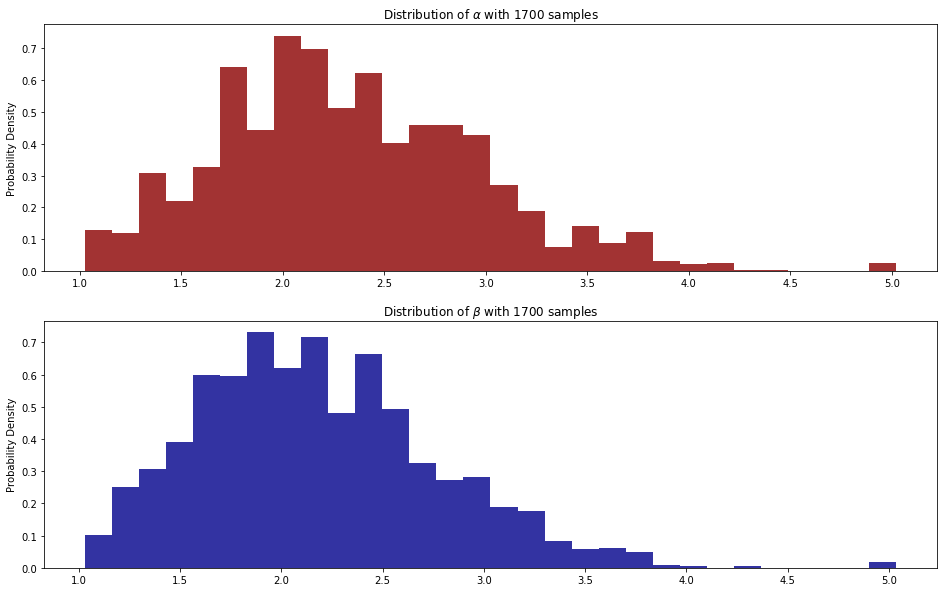

In [57]:
plt.figure(figsize=(16, 10))

plt.subplot(211)
plt.title(r"""Distribution of $\alpha$ with %d samples""" % alpha_samples.shape[0])

plt.hist(alpha_samples, histtype='stepfilled', 
         color = 'darkred', bins=30, alpha=0.8, density=True);
plt.ylabel('Probability Density')


plt.subplot(212)
plt.title(r"""Distribution of $\beta$ with %d samples""" % beta_samples.shape[0])
plt.hist(beta_samples, histtype='stepfilled', 
         color = 'darkblue', bins=30, alpha=0.8, density=True)
plt.ylabel('Probability Density');

In [101]:
def bayesian_beta(samples,loc=-1,scale=2,n_samples=1000):
    # known scaling
    scaled_samples = (samples - loc)/(scale)
    with pm.Model() as beta_model:
        alpha_dist = pm.Uniform('alpha',lower=1.0, upper=7.0)
        beta_dist = pm.Uniform('beta',lower=1.0, upper=7.0)
        observed = pm.Beta('obs',alpha=alpha_dist,beta=beta_dist,
                             observed=scaled_samples)
        #map_estimate = pm.find_MAP(model=beta_model)

        # Using Metropolis Hastings Sampling
        step = pm.Metropolis()

        # Sample from the posterior using the sampling method
        beta_trace = pm.sample(n_samples, step=step, njobs=4,progressbar=False,cores=4)
    return beta_model,beta_trace

In [59]:
from collections import defaultdict

def run_ppc(trace, samples=100, model=None):
    """Generate Posterior Predictive samples from a model given a trace.
    """
    if model is None:
         model = pm.modelcontext(model)

    ppc = defaultdict(list)
    for idx in np.random.randint(0, len(trace), samples):
        param = trace[idx]
        for obs in model.observed_RVs:
            ppc[obs.name].append(obs.distribution.random(point=param))

    return ppc

(array([ 3.,  7., 14., 12., 14., 18., 10.,  9.,  4.,  9.]),
 array([0.13037863, 0.21255438, 0.29473013, 0.37690588, 0.45908163,
        0.54125737, 0.62343312, 0.70560887, 0.78778462, 0.86996037,
        0.95213611]),
 <a list of 10 Patch objects>)

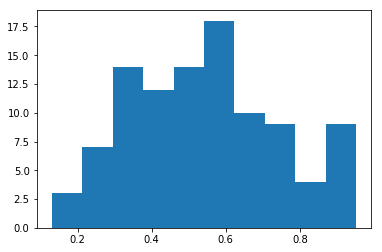

In [60]:
predictions = np.array(run_ppc(beta_trace,samples=100,model=beta_model)['obs'])
plt.hist(np.reshape(predictions,(-1,1)))

In [61]:
f1 = lambda x,y: -x*y + 5*x**2 + 2*x 
# concave function in x
f1_mean = lambda x,y: np.mean(f1(x,y),axis=0)

In [70]:
new_res = minimize(f1_mean,res.x,args=(predictions*2-1))
new_res.x

array([-0.19063769])

## Compare SAA with Bayes

In [ ]:
df = pd.DataFrame(columns=['method','N','x_star'])

In [112]:
n_trials = 500
N = [10,20,50]

In [113]:
for i in range(n_trials):
    for j in range(len(N)):
        samples = Y1.rvs(N[j])
        # compute saa
    
        res = minimize(f1_mean,0.0,args=(samples))
        results ={'method':'SAA','N':N[j],'x_star':res.x[0]}
        df = df.append(results,ignore_index=True)

        # compute bayesuian
        model,trace = bayesian_beta(samples)
        new_samples = np.array(run_ppc(trace, samples=200, model=model)['obs'])
        res = minimize(f1_mean,res.x,args=(new_samples*2-1))
        
        results ={'method':'Bayes','N':N[j],'x_star':res.x[0]}
        df = df.append(results,ignore_index=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective

The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [a

>Metropolis: [alpha]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4

CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective samples is smaller than 200 for 

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated

The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The 

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The number of

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The number of

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective samples i

CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The number of effective samples is smaller than 10% for some parameters.
Mul

>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The number of effective samples is smaller than 10% for some paramete

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The number of

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The number of effective samples i

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The number of effective samples i

CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The number of effective samples is smaller than 10% for some param

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective

KeyboardInterrupt: 

In [114]:
df.to_csv("bayes_results.csv")

In [122]:
samples = Y1.rvs(7000)
# compute saa
res = minimize(f1_mean,0.0,args=(samples))
true = res.x[0]

In [126]:
results =[{'method':'True','N':n,'x_star':res.x[0]} for n in N]
#df = df.append(results,ignore_index=True)

In [127]:
df = df.append(results,ignore_index=True)

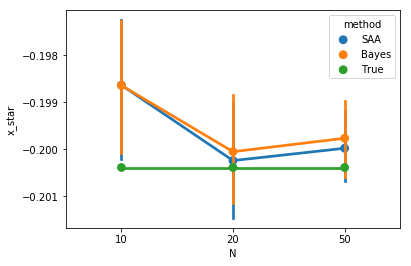

In [128]:
ax = sns.pointplot(x="N", y="x_star", hue="method",data=df)

In [129]:
samples = Y1.rvs(10000)
func = lambda x: np.mean(f1(x,samples))
df.loc[:,'expected_cost'] = df.loc[:,'x_star'].apply(func)

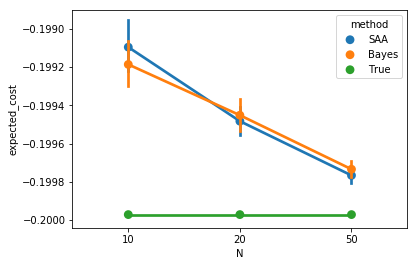

In [130]:
ax = sns.pointplot(x="N", y="expected_cost", hue="method",data=df)